In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
import seaborn as sns


In [9]:
data = loadmat('./datasets/satellite.mat')
X = np.array(data.get('X'))
y = np.array(data.get('y')).ravel().astype(int)

In [10]:
print(f"Zbiór danych satellite: {X.shape[0]} próbek, {X.shape[1]} cech, {np.sum(y)} anomalii ({100 * np.mean(y):.2f}% outlierów)")
all_results = []


Zbiór danych satellite: 6435 próbek, 36 cech, 2036 anomalii (31.64% outlierów)



=== Local Outlier Factor (LOF) ===

LOF (n_neighbors=5, contamination=0.01):
Macierz pomyłek:
 [[4366   33]
 [2004   32]]
AUC: 0.4996
Czas wykonania: 0.6229 s

LOF (n_neighbors=5, contamination=0.05):
Macierz pomyłek:
 [[4216  183]
 [1897  139]]
AUC: 0.4996
Czas wykonania: 0.5391 s

LOF (n_neighbors=5, contamination=0.1):
Macierz pomyłek:
 [[4005  394]
 [1786  250]]
AUC: 0.4996
Czas wykonania: 0.5454 s

LOF (n_neighbors=5, contamination=0.3):
Macierz pomyłek:
 [[3107 1292]
 [1397  639]]
AUC: 0.4996
Czas wykonania: 0.5247 s

LOF (n_neighbors=5, contamination=0.5):
Macierz pomyłek:
 [[2194 2205]
 [1024 1012]]
AUC: 0.4996
Czas wykonania: 0.5788 s

LOF (n_neighbors=10, contamination=0.01):
Macierz pomyłek:
 [[4370   29]
 [2000   36]]
AUC: 0.4778
Czas wykonania: 0.5571 s

LOF (n_neighbors=10, contamination=0.05):
Macierz pomyłek:
 [[4232  167]
 [1881  155]]
AUC: 0.4778
Czas wykonania: 0.5176 s

LOF (n_neighbors=10, contamination=0.1):
Macierz pomyłek:
 [[4014  385]
 [1777  259]]
AUC: 0.477

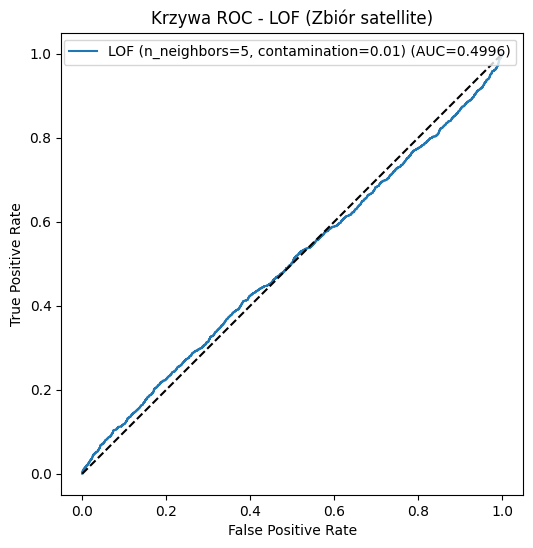

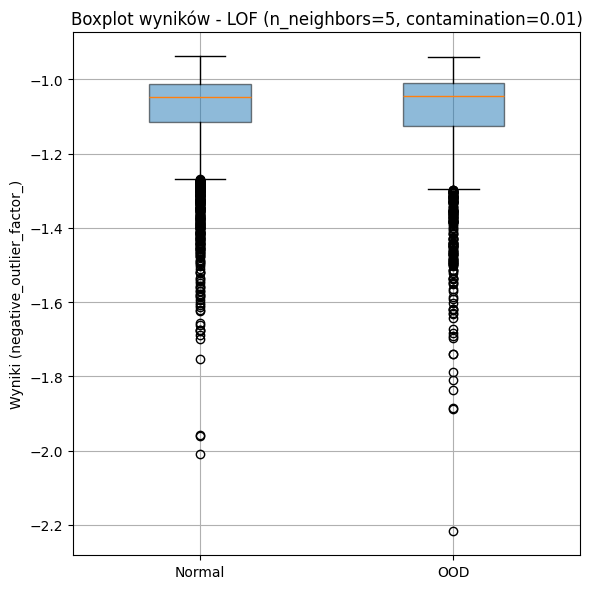

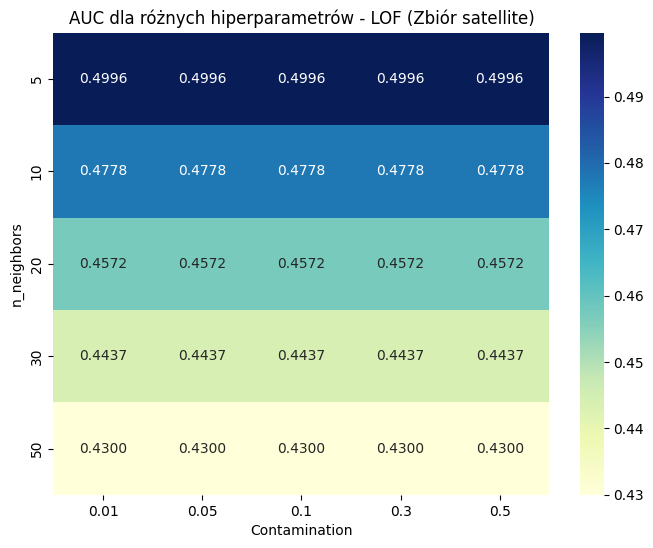

In [11]:
# 1. LOF
print("\n=== Local Outlier Factor (LOF) ===")
n_neighbors_list = [5, 10, 20, 30, 50]
contamination_list = [0.01, 0.05, 0.1, 0.3, 0.5]
lof_results = []

for n_neighbors in n_neighbors_list:
    for contamination in contamination_list:
        start_time = time.time()

        model_name = f"LOF (n_neighbors={n_neighbors}, contamination={contamination})"
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)

        y_pred = lof.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = lof.negative_outlier_factor_
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        lof_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_neighbors': n_neighbors,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_lof = max(lof_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego LOF
plt.figure(figsize=(6, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - LOF (Zbiór satellite)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego LOF
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_lof['normal_scores'], best_lof['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C0', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_lof["model_name"]}')
ax.set_ylabel('Wyniki (negative_outlier_factor_)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów LOF
auc_matrix = np.zeros((len(n_neighbors_list), len(contamination_list)))
for result in lof_results:
    i = n_neighbors_list.index(result['n_neighbors'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_neighbors_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_neighbors')
plt.title('AUC dla różnych hiperparametrów - LOF (Zbiór satellite)')
plt.show()


=== Isolation Forest ===

Isolation Forest (n_estimators=50, contamination=0.01):
Macierz pomyłek:
 [[4393    6]
 [1977   59]]
AUC: 0.6981
Czas wykonania: 0.0984 s

Isolation Forest (n_estimators=50, contamination=0.05):
Macierz pomyłek:
 [[4383   16]
 [1730  306]]
AUC: 0.6981
Czas wykonania: 0.0955 s

Isolation Forest (n_estimators=50, contamination=0.1):
Macierz pomyłek:
 [[4358   41]
 [1433  603]]
AUC: 0.6981
Czas wykonania: 0.0933 s

Isolation Forest (n_estimators=50, contamination=0.3):
Macierz pomyłek:
 [[3612  787]
 [ 892 1144]]
AUC: 0.6981
Czas wykonania: 0.0967 s

Isolation Forest (n_estimators=50, contamination=0.5):
Macierz pomyłek:
 [[2543 1856]
 [ 675 1361]]
AUC: 0.6981
Czas wykonania: 0.0944 s

Isolation Forest (n_estimators=100, contamination=0.01):
Macierz pomyłek:
 [[4396    3]
 [1974   62]]
AUC: 0.7215
Czas wykonania: 0.1816 s

Isolation Forest (n_estimators=100, contamination=0.05):
Macierz pomyłek:
 [[4387   12]
 [1726  310]]
AUC: 0.7215
Czas wykonania: 0.1852 s

I

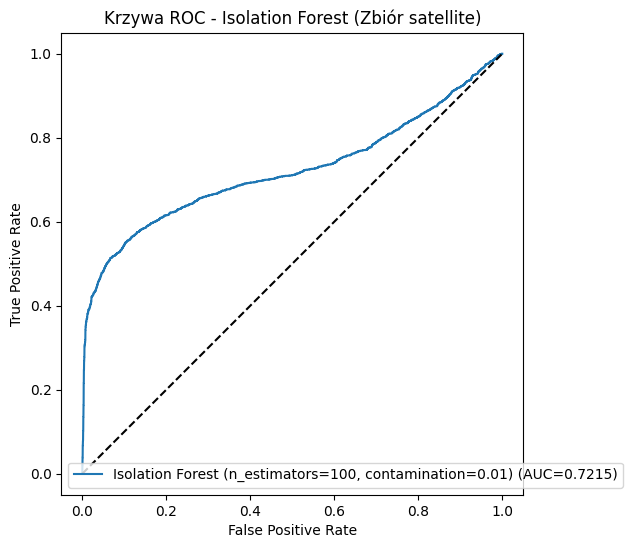

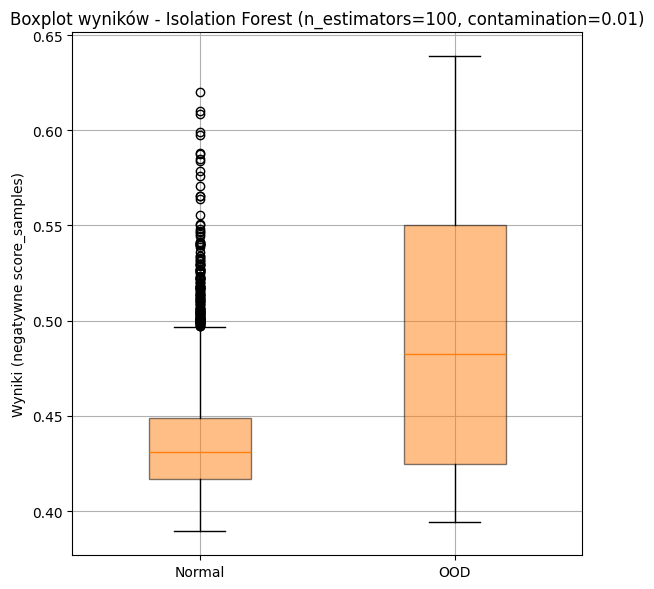

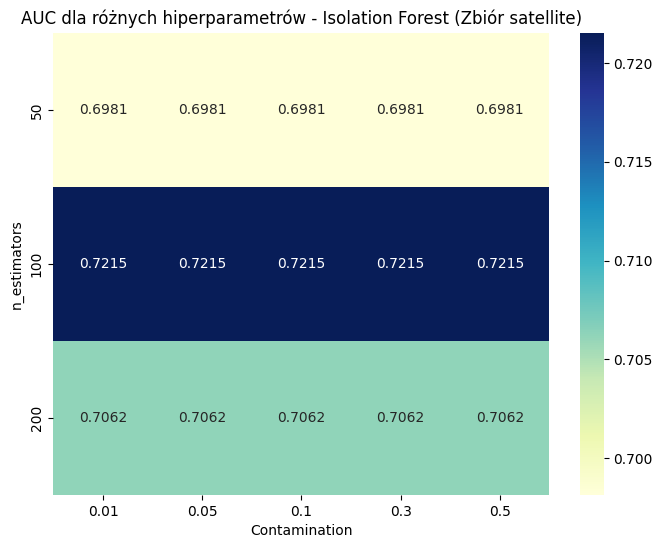

In [12]:
# 2. Isolation Forest
print("\n=== Isolation Forest ===")
n_estimators_list = [50, 100, 200]
contamination_list = [0.01, 0.05, 0.1, 0.3, 0.5]
iso_results = []

for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        start_time = time.time()

        model_name = f"Isolation Forest (n_estimators={n_estimators}, contamination={contamination})"
        iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)

        y_pred = iso_forest.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -iso_forest.score_samples(X)
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        iso_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_estimators': n_estimators,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_iso = max(iso_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego Isolation Forest
plt.figure(figsize=(6, 6))
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Isolation Forest (Zbiór satellite)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego Isolation Forest
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_iso['normal_scores'], best_iso['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C1', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_iso["model_name"]}')
ax.set_ylabel('Wyniki (negatywne score_samples)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów Isolation Forest
auc_matrix = np.zeros((len(n_estimators_list), len(contamination_list)))
for result in iso_results:
    i = n_estimators_list.index(result['n_estimators'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_estimators_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_estimators')
plt.title('AUC dla różnych hiperparametrów - Isolation Forest (Zbiór satellite)')
plt.show()



=== One-Class SVM ===

One-Class SVM (nu=0.01, gamma=0.001):
Macierz pomyłek:
 [[4067  332]
 [1642  394]]
AUC: 0.6439
Czas wykonania: 1.7637 s

One-Class SVM (nu=0.01, gamma=0.01):
Macierz pomyłek:
 [[2035 2364]
 [1080  956]]
AUC: 0.4681
Czas wykonania: 7.8146 s

One-Class SVM (nu=0.01, gamma=scale):
Macierz pomyłek:
 [[4381   18]
 [1989   47]]
AUC: 0.5130
Czas wykonania: 0.1222 s

One-Class SVM (nu=0.05, gamma=0.001):
Macierz pomyłek:
 [[4089  310]
 [1646  390]]
AUC: 0.6451
Czas wykonania: 1.7938 s

One-Class SVM (nu=0.05, gamma=0.01):
Macierz pomyłek:
 [[2564 1835]
 [1306  730]]
AUC: 0.4723
Czas wykonania: 7.8620 s

One-Class SVM (nu=0.05, gamma=scale):
Macierz pomyłek:
 [[4299  100]
 [1814  222]]
AUC: 0.5423
Czas wykonania: 0.4535 s

One-Class SVM (nu=0.1, gamma=0.001):
Macierz pomyłek:
 [[4045  354]
 [1576  460]]
AUC: 0.6465
Czas wykonania: 1.8238 s

One-Class SVM (nu=0.1, gamma=0.01):
Macierz pomyłek:
 [[2502 1897]
 [1280  756]]
AUC: 0.4746
Czas wykonania: 7.9099 s

One-Class SVM

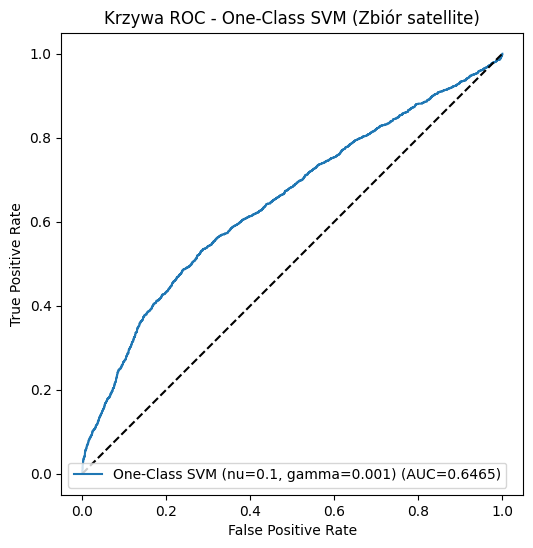

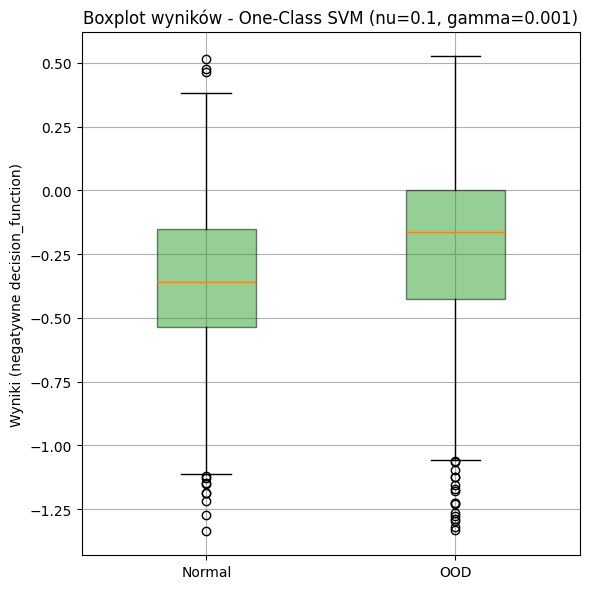

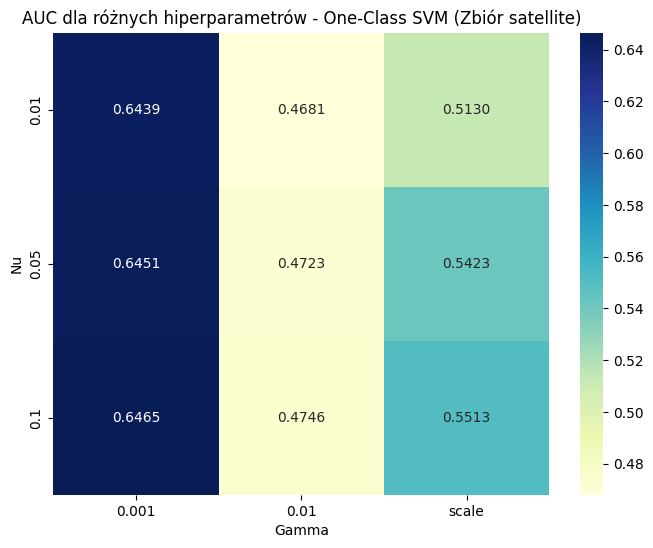

In [13]:
# 3. One-Class SVM
print("\n=== One-Class SVM ===")
nu_list = [0.01, 0.05, 0.1]
gamma_list = [0.001, 0.01, 'scale']
svm_results = []

for nu in nu_list:
    for gamma in gamma_list:
        start_time = time.time()

        model_name = f"One-Class SVM (nu={nu}, gamma={gamma})"
        ocsvm = OneClassSVM(nu=nu, gamma=gamma, kernel='rbf')

        y_pred = ocsvm.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -ocsvm.decision_function(X)
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        svm_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'nu': nu,
            'gamma': gamma
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_svm = max(svm_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego One-Class SVM
plt.figure(figsize=(6, 6))
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - One-Class SVM (Zbiór satellite)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego One-Class SVM
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_svm['normal_scores'], best_svm['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C2', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_svm["model_name"]}')
ax.set_ylabel('Wyniki (negatywne decision_function)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów One-Class SVM
auc_matrix = np.zeros((len(nu_list), len(gamma_list)))
for result in svm_results:
    i = nu_list.index(result['nu'])
    j = gamma_list.index(result['gamma'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=gamma_list, yticklabels=nu_list, cmap='YlGnBu')
plt.xlabel('Gamma')
plt.ylabel('Nu')
plt.title('AUC dla różnych hiperparametrów - One-Class SVM (Zbiór satellite)')
plt.show()

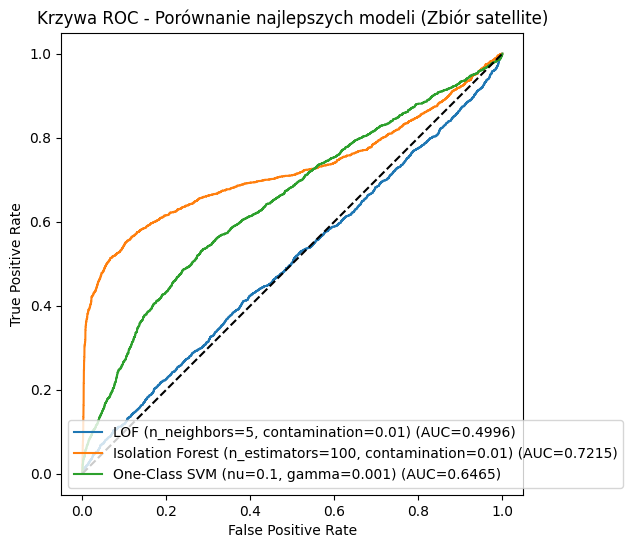


Podsumowanie wyników:
                                                Model       AUC  \
0             LOF (n_neighbors=5, contamination=0.01)  0.499614   
1             LOF (n_neighbors=5, contamination=0.05)  0.499614   
2              LOF (n_neighbors=5, contamination=0.1)  0.499614   
3              LOF (n_neighbors=5, contamination=0.3)  0.499614   
4              LOF (n_neighbors=5, contamination=0.5)  0.499614   
5            LOF (n_neighbors=10, contamination=0.01)  0.477844   
6            LOF (n_neighbors=10, contamination=0.05)  0.477844   
7             LOF (n_neighbors=10, contamination=0.1)  0.477844   
8             LOF (n_neighbors=10, contamination=0.3)  0.477844   
9             LOF (n_neighbors=10, contamination=0.5)  0.477844   
10           LOF (n_neighbors=20, contamination=0.01)  0.457179   
11           LOF (n_neighbors=20, contamination=0.05)  0.457179   
12            LOF (n_neighbors=20, contamination=0.1)  0.457179   
13            LOF (n_neighbors=20, cont

In [14]:
# Porównawczy wykres ROC dla wszystkich najlepszych modeli
plt.figure(figsize=(8, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Porównanie najlepszych modeli (Zbiór satellite)')
plt.legend()
plt.axis('square')
plt.show()

# Zapis wyników do DataFrame
results_df = pd.DataFrame(all_results)
print("\nPodsumowanie wyników:")
print(results_df)